In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotions/text.csv


In [59]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
df = pd.read_csv('/kaggle/input/emotions/text.csv')

# Data Exploration

In [61]:
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [62]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [64]:
df.duplicated().sum()

686

In [65]:
df = df.drop_duplicates()

In [66]:
# mapping emotions
emotion_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

df['label_emotion'] = df['label'].map(emotion_map)

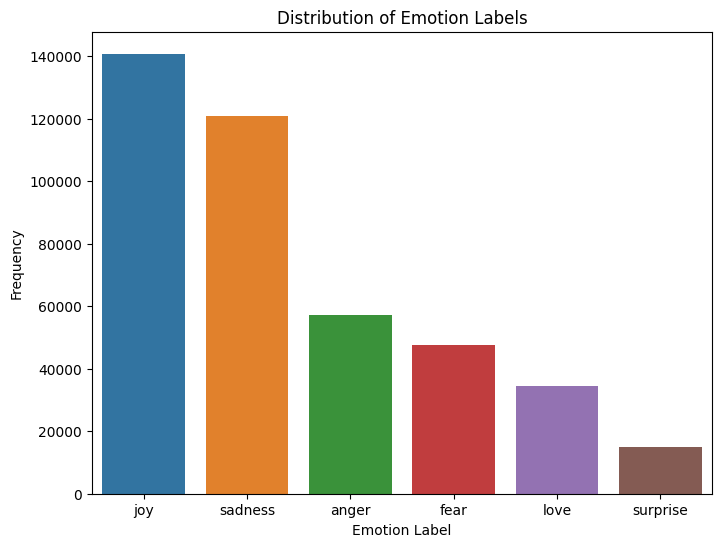

In [67]:
# Check label distribution
label_counts = df['label_emotion'].value_counts()

# Plot label distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Emotion Labels')
plt.xlabel('Emotion Label')
plt.ylabel('Frequency')
plt.show()

In [11]:
label_counts

label
joy         140779
sadness     120989
anger        57235
fear         47664
love         34497
surprise     14959
Name: count, dtype: int64

# Data Cleaning & Preprocessing

In [12]:
# removing punctuation and special characters, digits, white spaces
df['text'] = df['text'].str.replace('[^\w\s]', '')

In [13]:
#converting to lower case
df['text'] = df['text'].str.lower()

In [14]:
# removing url's
df['text'] = df['text'].str.replace(r'https?://\S+|www\.\S+', '', regex=True)

Perform Lemmatization

In [15]:
#nltk.download()

In [16]:
#!unzip /root/nltk_data/corpora/wordnet.zip -d /root/nltk_data/corpora/

In [17]:
#!pip install spacy
#!python -m spacy download en_core_web_sm

In [18]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [19]:
# Function to remove stop words using SpaCy
def remove_stopwords(text):
    doc = nlp(text)
    filtered_text = [token.text for token in doc if not token.is_stop]
    return ' '.join(filtered_text)

df['text'] = df['text'].apply(remove_stopwords)

In [ ]:
import concurrent.futures

def lemmatize_spacy(text):
    doc = nlp(text)
    lemma_words = [token.lemma_ for token in doc]
    lemma_text = ' '.join(lemma_words)
    return lemma_text

# Example batch processing with parallelism
batch_size = 1000
num_batches = len(df) // batch_size + 1

def parallel(batch_texts):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = executor.map(lemmatize_spacy, batch_texts)
    return list(results)

# Process batches in parallel
processed_texts = []
for i in range(num_batches):
    batch_texts = df['text'][i * batch_size : (i + 1) * batch_size]
    processed_batch = parallel(batch_texts)
    processed_texts.extend(processed_batch)

df['text'] = processed_texts


In [29]:
import concurrent.futures
# Example parallel processing using concurrent.futures
def process_batch(batch_texts):
    return [lemmatize_text_spacy(text) for text in batch_texts]

batch_size = 1000
num_batches = len(df) // batch_size + 1

with concurrent.futures.ProcessPoolExecutor() as executor:
    results = executor.map(process_batch, [df['text'][i * batch_size : (i + 1) * batch_size] for i in range(num_batches)])

processed_texts = []
for result in results:
    processed_texts.extend(result)

df['text'] = processed_texts

In [ ]:

# Load SpaCy English language model
nlp = spacy.load('en_core_web_sm')

def lemmatize_text_spacy(text):
    doc = nlp(text)
    lemma_words = [token.lemma_ for token in doc]
    lemma_text = ' '.join(lemma_words)
    return lemma_text

df['text'] = df['text'].apply(lemmatize_text_spacy)

In [30]:
df['text'][0:5]

0                          feel helpless heavy hearted
1    ve enjoy able slouch relax unwind frankly need...
2                 give internship dmrg feel distraught
3                                   not know feel lost
4    kindergarten teacher thoroughly weary job havi...
Name: text, dtype: object

In [31]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000) 
tfidf_features = tfidf_vectorizer.fit_transform(df['text']).toarray()

# Convert TF-IDF features to DataFrame for visualization
tfidf_df = pd.DataFrame(tfidf_features, columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.head()

,ability,able,absolutely,abuse,accept,acceptable,ache,achieve,act,action,...,wouldn,write,writer,writing,wrong,www,year,yes,yesterday,young
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.272136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Separate features and labels
#X = tfidf_features
#y = df['label']

# Apply SMOTE for oversampling
#smote = SMOTE(random_state=50)
#X_resampled, y_resampled = smote.fit_resample(X, y)

In [32]:
from imblearn.under_sampling import RandomUnderSampler

# Separate features and labels
X = tfidf_features
y = df['label']

# Apply Random Undersampling for downsampling
undersampler = RandomUnderSampler(random_state=50)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Data Modelling - Part 1 (Exploring Deep Learning Models)

In [33]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [34]:
# Encode emotion labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

In [46]:
df['label_encoded'] [:5]

0    1
1    4
2    1
3    4
4    1
Name: label_encoded, dtype: int64

In [35]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=50)

In [49]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [50]:
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [51]:
y_train_encoded

array([2, 5, 4, ..., 3, 1, 0])

In [36]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Convert X_train and X_test (numpy arrays) to lists of strings and lowercase them
X_train_texts = [str(text).lower() for text in X_train]
X_test_texts = [str(text).lower() for text in X_test]

# Initialize Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_texts)

vocab_size = len(tokenizer.word_index) + 1
max_seq_length = 100  # Define maximum sequence length

# Convert text sequences to numerical sequences (sequences of token IDs)
X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
X_test_seq = tokenizer.texts_to_sequences(X_test_texts)

# Pad sequences to ensure uniform length for modeling
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=max_seq_length, padding='post')
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=max_seq_length, padding='post')

In [38]:
embedding_dim = 100 

# Define the Sequential model
model = Sequential([
    Embedding(input_dim=vocab_size, 
              output_dim=embedding_dim),
    LSTM(units=128, dropout=0.2, recurrent_dropout=0.2),
    Dense(6, activation='softmax')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
num_epochs = 10  # Define number of epochs
batch_size = 32  # Define batch size

history = model.fit(X_train_padded, y_train_encoded, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test_padded, y_test_encoded))

Epoch 1/10
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 394s 176ms/step - accuracy: 0.1687 - loss: 1.7925 - val_accuracy: 0.1665 - val_loss: 1.7919
Epoch 2/10
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 393s 175ms/step - accuracy: 0.1695 - loss: 1.7920 - val_accuracy: 0.1635 - val_loss: 1.7919
Epoch 3/10
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 393s 175ms/step - accuracy: 0.1738 - loss: 1.7922 - val_accuracy: 0.1663 - val_loss: 1.7920
Epoch 4/10
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 392s 175ms/step - accuracy: 0.1755 - loss: 1.7840 - val_accuracy: 0.1634 - val_loss: 1.7938
Epoch 5/10
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 394s 176ms/step - accuracy: 0.1876 - loss: 1.7579 - val_accuracy: 0.1666 - val_loss: 1.7959
Epoch 6/10
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 392s 175ms/step - accuracy: 0.2395 - loss: 1.6920 - val_accuracy: 0.1664 - val_loss: 1.8008
Epoch 7/10
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 392s 175ms/step - accuracy: 0.3460 - loss: 1.4756 - val_accuracy: 0.1769 - val_loss: 1.8182
Epoch 8/10
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 392s 175ms/step - ac

In [55]:
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

561/561 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - accuracy: 0.1787 - loss: 1.8364
Test Loss: 1.8429144620895386, Test Accuracy: 0.17714890837669373


In [56]:
new_texts = ['This is a joyful moment', 'I feel sad today','This is a fine moment', 'I feel okay today']
new_texts_seq = tokenizer.texts_to_sequences(new_texts)
new_texts_padded = tf.keras.preprocessing.sequence.pad_sequences(new_texts_seq, maxlen=max_seq_length, padding='post')

predictions = model.predict(new_texts_padded)
predicted_labels = label_encoder.inverse_transform(predictions.argmax(axis=1))
print(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
['surprise' 'surprise' 'surprise' 'surprise']


In [57]:
# Predictions On Test For Confustion Matrix 
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)

561/561 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step


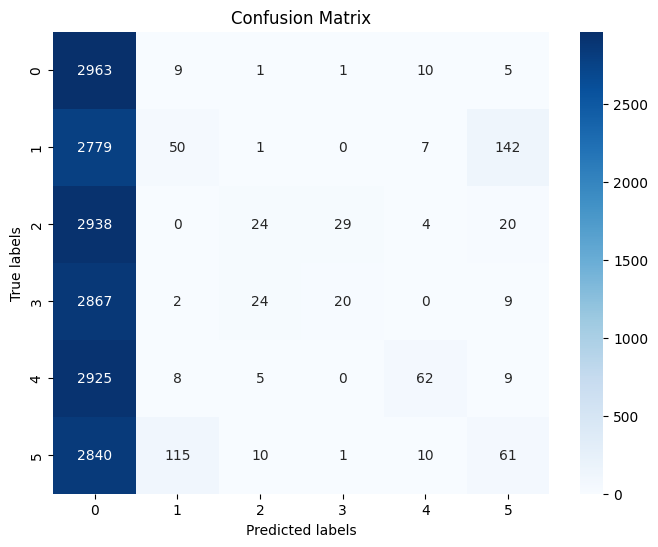

In [69]:
# y_test and y_pred are your true and predicted labels
cm_lstm = confusion_matrix(y_test_encoded, y_pred)

# Plot confusion matrix with blue color
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues') 
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [70]:
cm_lstm

array([[2963,    9,    1,    1,   10,    5],
       [2779,   50,    1,    0,    7,  142],
       [2938,    0,   24,   29,    4,   20],
       [2867,    2,   24,   20,    0,    9],
       [2925,    8,    5,    0,   62,    9],
       [2840,  115,   10,    1,   10,   61]])